In [1]:
from basics import *
from plotting import *
from matplotlib import cm
from dscribe.descriptors import SOAP
from pymatgen.core import Structure, Molecule
from pymatgen.io.ase import AseAtomsAdaptor
from mkite_catalysis.runners.coverage import CoverageGenerator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import umap

plt.style.use("paper")

In [2]:
cutoffs = {
    111: 1.0,
    100: 1.0,
    211: 1.4,
    331: 1.6,
    410: 1.2,
    711: 1.8
}

COLORS = {
    100: cm.tab10(0),
    111: cm.tab10(1),
    211: cm.tab10(2),
    331: cm.tab10(3),
    410: cm.tab10(4),
    711: cm.tab10(5)
}

crystals = {
    facet: Structure.from_file(f"../data/01-facets/{facet}.POSCAR")
    for facet in cutoffs.keys()
}

pos = np.array([
    [0, 0, -0.5641],
    [0, 0,  0.5641],
])
ads = Molecule(species=["C", "O"], coords=pos)

## SOAP vectors

In [3]:
soap = SOAP(
    r_cut=5.0,
    n_max=7,
    l_max=6,
    sigma=0.3,
    species=["Cu"],
    periodic=True
)

In [4]:
vecs, labels = [], []

for facet, s in crystals.items():
    cutoff = cutoffs.get(facet, 0.9)
    cgen = CoverageGenerator(s, ads, surface_height=cutoff)
    finder = cgen.get_finder()
    sites = np.array(finder.find_adsorption_sites(distance=2.0)["all"])
    
    at = AseAtomsAdaptor.get_atoms(s)
    v = soap.create(at, centers=list(sites))
    
    vecs += [v]
    labels += [facet] * len(sites)

vecs = np.concatenate(vecs, axis=0)

## Visualization

In [5]:
pca = PCA(2)
xy = pca.fit_transform(vecs)

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_96416/787856105.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xy[idx, 0], xy[idx, 1], c=COLORS[facet], s=40, edgecolors="k", linewidth=0.3, alpha=1.0)


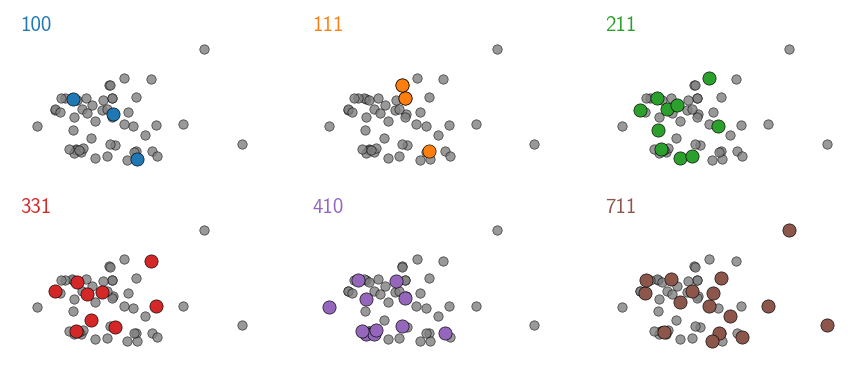

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(6, 2.6), sharex=True, sharey=True)

colors = [COLORS[f] for f in labels]
label_set = sorted(list(set(labels)))

pad = 0.1
xlim = (xy[:, 0].min() - pad, xy[:, 0].max() + pad)
ylim = (xy[:, 1].min() - pad, xy[:, 1].max() + pad)

for i, ax in enumerate(axs.ravel()):
    ax.scatter(xy[:, 0], xy[:, 1], c="#808080", s=20, edgecolors="k", linewidth=0.3, alpha=0.8)
    
    facet = label_set[i]
    idx = [l == facet for l in labels]
    ax.scatter(xy[idx, 0], xy[idx, 1], c=COLORS[facet], s=40, edgecolors="k", linewidth=0.3, alpha=1.0)

    ax.set_aspect("equal")
    for spine in ["left", "right", "top", "bottom"]:
        ax.spines[spine].set_visible(False)
    
    ax.annotate(facet, (0.02, 0.98), xycoords="axes fraction", color=COLORS[facet])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig.tight_layout()
savefig(fig, "02-extrapolation-pca.pdf")
plt.show()

## UMAP

In [7]:
reducer = umap.UMAP(metric="cosine", random_state=45)
xy = reducer.fit_transform(vecs)

/Users/schwalbekoda1/envs/mkite-cov/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_96416/2755541654.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xy[idx, 0], xy[idx, 1], c=COLORS[facet], s=40, edgecolors="k", linewidth=0.3, alpha=1.0)


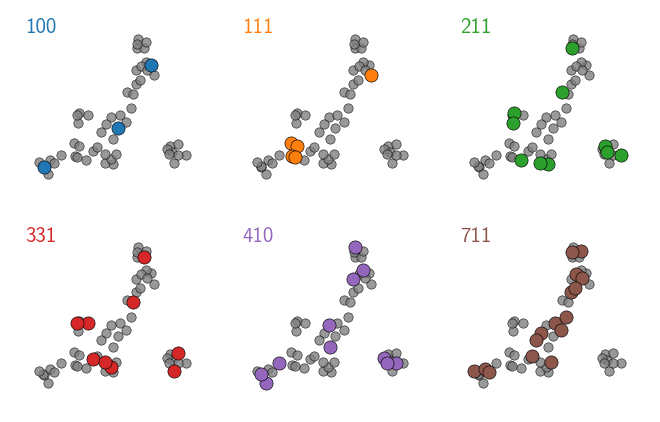

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(4.5, 3), sharex=True, sharey=True)

colors = [COLORS[f] for f in labels]
label_set = sorted(list(set(labels)))

pad = 1
xlim = (xy[:, 0].min() - pad, xy[:, 0].max() + pad)
ylim = (xy[:, 1].min() - pad, xy[:, 1].max() + pad)

for i, ax in enumerate(axs.ravel()):
    ax.scatter(xy[:, 0], xy[:, 1], c="#808080", s=20, edgecolors="k", linewidth=0.3, alpha=0.8)
    
    facet = label_set[i]
    idx = [l == facet for l in labels]
    ax.scatter(xy[idx, 0], xy[idx, 1], c=COLORS[facet], s=40, edgecolors="k", linewidth=0.3, alpha=1.0)

    ax.set_aspect("equal")
    for spine in ["left", "right", "top", "bottom"]:
        ax.spines[spine].set_visible(False)
    
    ax.annotate(facet, (0.05, 0.90), xycoords="axes fraction", color=COLORS[facet])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig.tight_layout()
savefig(fig, "02-extrapolation-umap.pdf")
plt.show()